In [ ]:
# Install torch and torchvision
!pip install torch torchvision

# Install datasets library
!pip install datasets

# Install numpy (already pre-installed in Colab but can be reinstalled if needed)
!pip install numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install datasets
!pip install torchvision

Mounted at /content/drive


In [ ]:
from PIL import Image
img = Image.open("/content/drive/MyDrive/Dataset/images_png/train/100.png")
print(img.mode)  # 'L' for grayscale, 'RGB' for color

L


In [ ]:
from torchvision import transforms
import torch

def preprocess(batch):
    # Convert images to RGB (3 channels)
    images = [img.convert('RGB') for img in batch['image']]
    # Convert masks to grayscale (1 channel)
    masks = [mask.convert('L') for mask in batch['segmentation_mask']]

    # Resize images and masks to 512x512
    images = [transforms.Resize((512, 512))(img) for img in images]
    masks = [transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BILINEAR)(mask) for mask in masks]

    # Convert images to tensors and normalize
    images = [transforms.ToTensor()(img) for img in images]
    #images = [transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img) for img in images]

    # Convert masks to Long tensors and map to 0 and 1
    masks = [transforms.functional.pil_to_tensor(mask).long() for mask in batch['segmentation_mask']]
    masks = [mask.squeeze(0) for mask in masks]  # Remove channel dimension
    masks = [(mask > 0).long() for mask in masks]  # Map any non-zero value to 1, keep as Long

    return {"pixel_values": images, "labels": masks}

In [ ]:
from datasets import Dataset, Features, Image
import os

# Define paths for training data (update based on your folder structure)
train_image_dir = "/content/drive/MyDrive/Dataset/images_png/train/"
train_mask_dir = "/content/drive/MyDrive/Dataset/masks_png/train1/"

# Get sorted lists of training file paths
train_image_files = sorted([os.path.join(train_image_dir, f) for f in os.listdir(train_image_dir) if f.endswith('.png')])
train_mask_files = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir) if f.endswith('.png')])

# Verify matching number of images and masks
assert len(train_image_files) == len(train_mask_files), "Number of training images and masks must be equal"

# Create training dataset dictionary
train_dataset_dict = {
    "image": train_image_files,
    "segmentation_mask": train_mask_files
}

# Define features
features = Features({
    "image": Image(),
    "segmentation_mask": Image()
})

# Create the training dataset
train_dataset = Dataset.from_dict(train_dataset_dict, features=features)

# Set the preprocessing transform
train_dataset.set_transform(preprocess)

# Define paths for validation data
val_image_dir = "/content/drive/MyDrive/Dataset//images_png/test/"
val_mask_dir = "/content/drive/MyDrive/Dataset/masks_png/test1/"

# Get sorted lists of validation file paths
val_image_files = sorted([os.path.join(val_image_dir, f) for f in os.listdir(val_image_dir) if f.endswith('.png')])
val_mask_files = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir) if f.endswith('.png')])

# Verify matching number of images and masks
assert len(val_image_files) == len(val_mask_files), "Number of validation images and masks must be equal"

# Create validation dataset dictionary
val_dataset_dict = {
    "image": val_image_files,
    "segmentation_mask": val_mask_files
}

# Create the validation dataset
val_dataset = Dataset.from_dict(val_dataset_dict, features=features)

# Set the preprocessing transform
val_dataset.set_transform(preprocess)

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn

# Load pre-trained DeepLabV3+ with ResNet50 backbone
model = deeplabv3_resnet50(pretrained=True)

# Modify the classifier for 2 classes
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 157MB/s]


In [ ]:
from torch.utils.data import DataLoader

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
import torch

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, batch in enumerate(train_loader):
        images = batch['pixel_values'].to(device)
        masks = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']  # DeepLabV3+ outputs a dict with 'out'
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Print loss every 10 batches to prevent Colab disconnection
        if i % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {i}, Loss: {loss.item()}")

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}")


Epoch 1, Batch 0, Loss: 0.6280835866928101
Epoch 1, Batch 10, Loss: 0.46108168363571167
Epoch 1, Batch 20, Loss: 0.2651709020137787
Epoch 1, Batch 30, Loss: 0.24160517752170563
Epoch 1, Batch 40, Loss: 0.517206072807312
Epoch 1, Batch 50, Loss: 0.28775539994239807
Epoch 1, Batch 60, Loss: 0.27376872301101685
Epoch 1, Batch 70, Loss: 0.20368759334087372
Epoch 1, Batch 80, Loss: 0.20529122650623322
Epoch 1, Batch 90, Loss: 0.1884029507637024
Epoch 1, Batch 100, Loss: 0.20395687222480774
Epoch 1, Batch 110, Loss: 0.5067175626754761
Epoch 1, Batch 120, Loss: 0.2400679737329483
Epoch 1, Batch 130, Loss: 0.13423870503902435
Epoch 1, Batch 140, Loss: 0.11704221367835999
Epoch 1, Batch 150, Loss: 0.17858469486236572
Epoch 1, Batch 160, Loss: 0.23336002230644226
Epoch 1, Batch 170, Loss: 0.19116976857185364
Epoch 1, Batch 180, Loss: 0.10364639759063721
Epoch 1, Batch 190, Loss: 0.27877572178840637
Epoch 1, Batch 200, Loss: 0.15991614758968353
Epoch 1, Batch 210, Loss: 0.5235338807106018
Epoch 1

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model1.pth')

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/model1.pth"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
model.eval()
val_loss = 0.0
val_accuracy = 0.0
with torch.no_grad():
    for batch in val_loader:
        images = batch['pixel_values'].to(device)
        masks = batch['labels'].to(device)
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        val_loss += loss.item()

        # Compute pixel accuracy
        preds = torch.argmax(outputs, dim=1)
        correct = (preds == masks).sum().item()
        total = masks.numel()
        val_accuracy += correct / total

val_loss /= len(val_loader)
val_accuracy /= len(val_loader)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Validation Loss: 0.18591351325130745, Validation Accuracy: 0.9431819915771484


In [ ]:
import torch
import numpy as np

# Function to compute IoU for each class
def compute_iou(preds, targets, num_classes):
    """
    Compute IoU for each class.

    Args:
        preds (torch.Tensor): Predicted class labels (shape: [batch_size, height, width])
        targets (torch.Tensor): Ground truth labels (shape: [batch_size, height, width])
        num_classes (int): Number of classes (e.g., 2 for background and object)

    Returns:
        list: IoU for each class
    """
    ious = []
    for cls in range(num_classes):
        # Binary masks for the current class
        pred_cls = (preds == cls)  # Predicted pixels for class
        target_cls = (targets == cls)  # Ground truth pixels for class

        # Compute intersection and union
        intersection = (pred_cls & target_cls).sum().item()  # True positives
        union = (pred_cls | target_cls).sum().item()  # TP + FP + FN

        # Handle division by zero (class not present in batch)
        if union == 0:
            iou = float('nan')  # Exclude from mean calculation
        else:
            iou = intersection / union
        ious.append(iou)
    return ious

# Evaluation on the test set
def evaluate(model, test_loader, criterion, device, num_classes=2):
    """
    Evaluate the model on the test set and compute class-wise IoU and mean IoU.

    Args:
        model: Trained segmentation model
        test_loader: DataLoader for the test set
        criterion: Loss function
        device: Device to run the model on (e.g., 'cuda' or 'cpu')
        num_classes (int): Number of classes in the segmentation task
    """
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    test_accuracy = 0.0
    all_ious = []  # Store IoU for each batch

    with torch.no_grad():  # Disable gradient computation
        for batch in test_loader:
            # Assuming batch contains 'pixel_values' (images) and 'labels' (masks)
            images = batch['pixel_values'].to(device)
            masks = batch['labels'].to(device)

            # Forward pass
            outputs = model(images)['out']  # Model output (logits)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            # Get predicted class labels
            preds = torch.argmax(outputs, dim=1)  # Shape: [batch_size, height, width]

            # Compute pixel accuracy
            correct = (preds == masks).sum().item()
            total = masks.numel()  # Total number of pixels
            test_accuracy += correct / total

            # Compute IoU for this batch
            ious = compute_iou(preds, masks, num_classes)
            all_ious.append(ious)

    # Calculate average metrics
    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)

    # Convert IoU list to numpy array for easier computation
    all_ious = np.array(all_ious)  # Shape: [num_batches, num_classes]

    # Compute class-wise IoU (mean over batches, ignoring nan)
    class_wise_iou = np.nanmean(all_ious, axis=0)  # IoU per class

    # Compute mean IoU (average across classes)
    mean_iou = np.nanmean(class_wise_iou)

    # Print results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Class-wise IoU: {class_wise_iou}")
    print(f"Mean IoU: {mean_iou:.4f}")

    return test_loss, test_accuracy, class_wise_iou, mean_iou

# Example usage
# Assuming model, test_loader, criterion, and device are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy, class_wise_iou, mean_iou = evaluate(model, val_loader, criterion, device, num_classes=2)

Test Loss: 0.1859
Test Accuracy: 0.9432
Class-wise IoU: [0.9278198  0.76686634]
Mean IoU: 0.8473


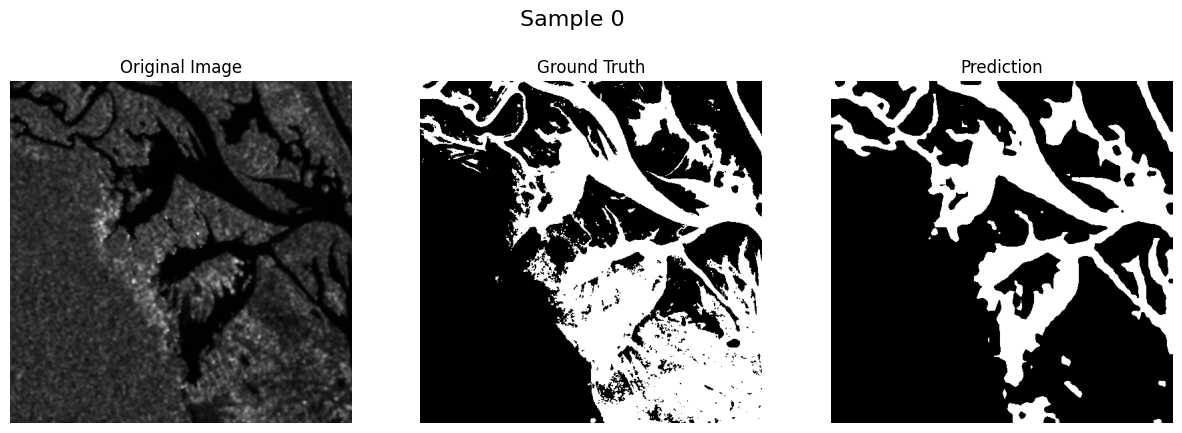

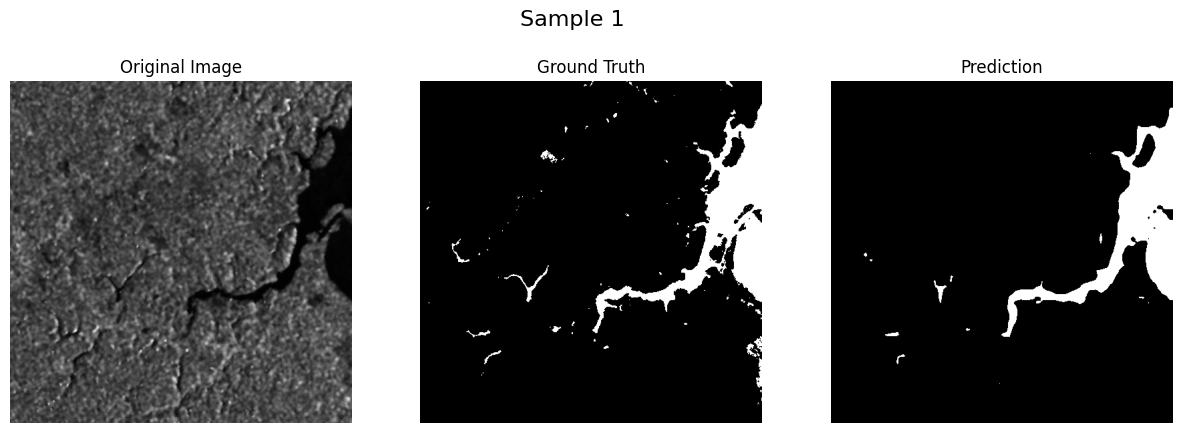

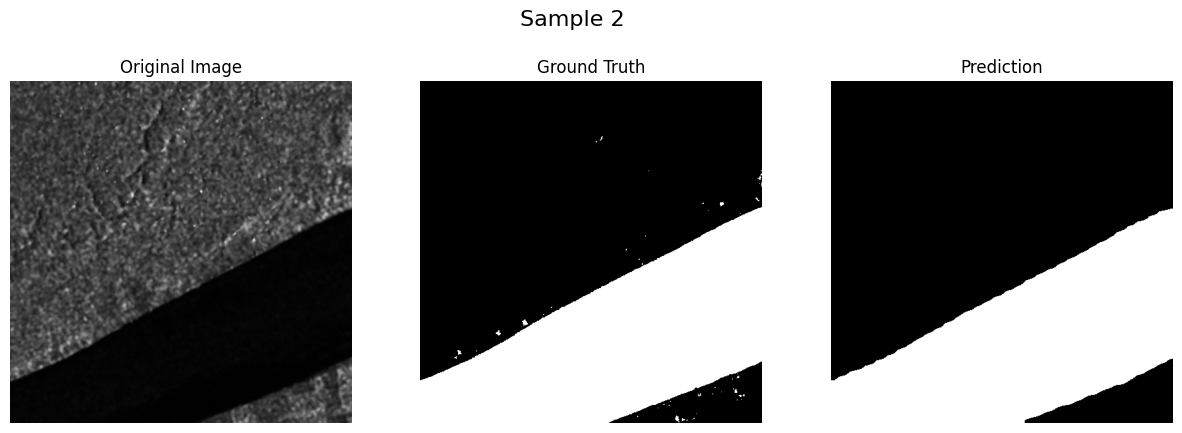

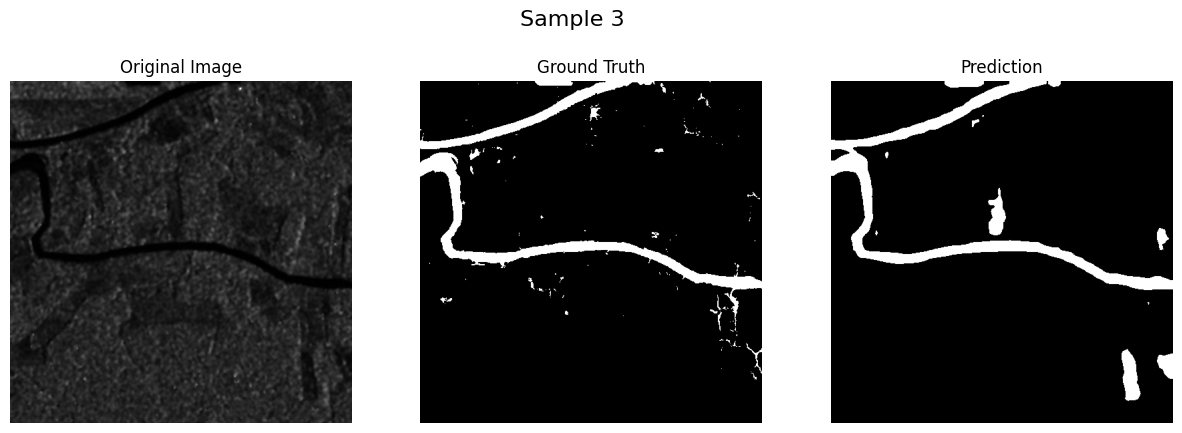

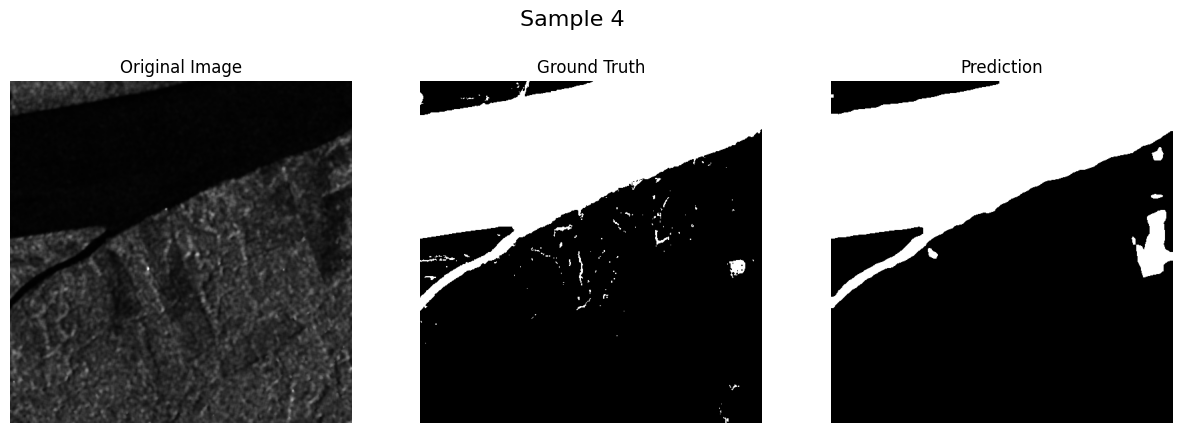

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Inverse normalization (if applicable)
#inv_normalize = transforms.Normalize(
 #   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
#    std=[1/0.229, 1/0.224, 1/0.225]
#)

# Select indices
indices = [0, 1, 2, 3, 4]# Prediction function
def get_prediction(model, image):
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))['out']
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    return pred

# Visualization function
def visualize(image, mask, pred, idx):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Sample {idx}', fontsize=16)

    #if image.shape[0] == 3:
       # image = inv_normalize(image).permute(1, 2, 0).numpy()
    #else:
    image = image.permute(1, 2, 0).numpy()
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title('Prediction')
    axes[2].axis('off')

    plt.show()

# Visualize 4-5 samples (replace 'test_dataset' with your dataset)
for i, idx in enumerate(indices):
    sample = val_dataset[idx]
    image = sample['pixel_values']
    mask = sample['labels'].numpy()
    pred = get_prediction(model, image)
    visualize(image, mask, pred, idx)

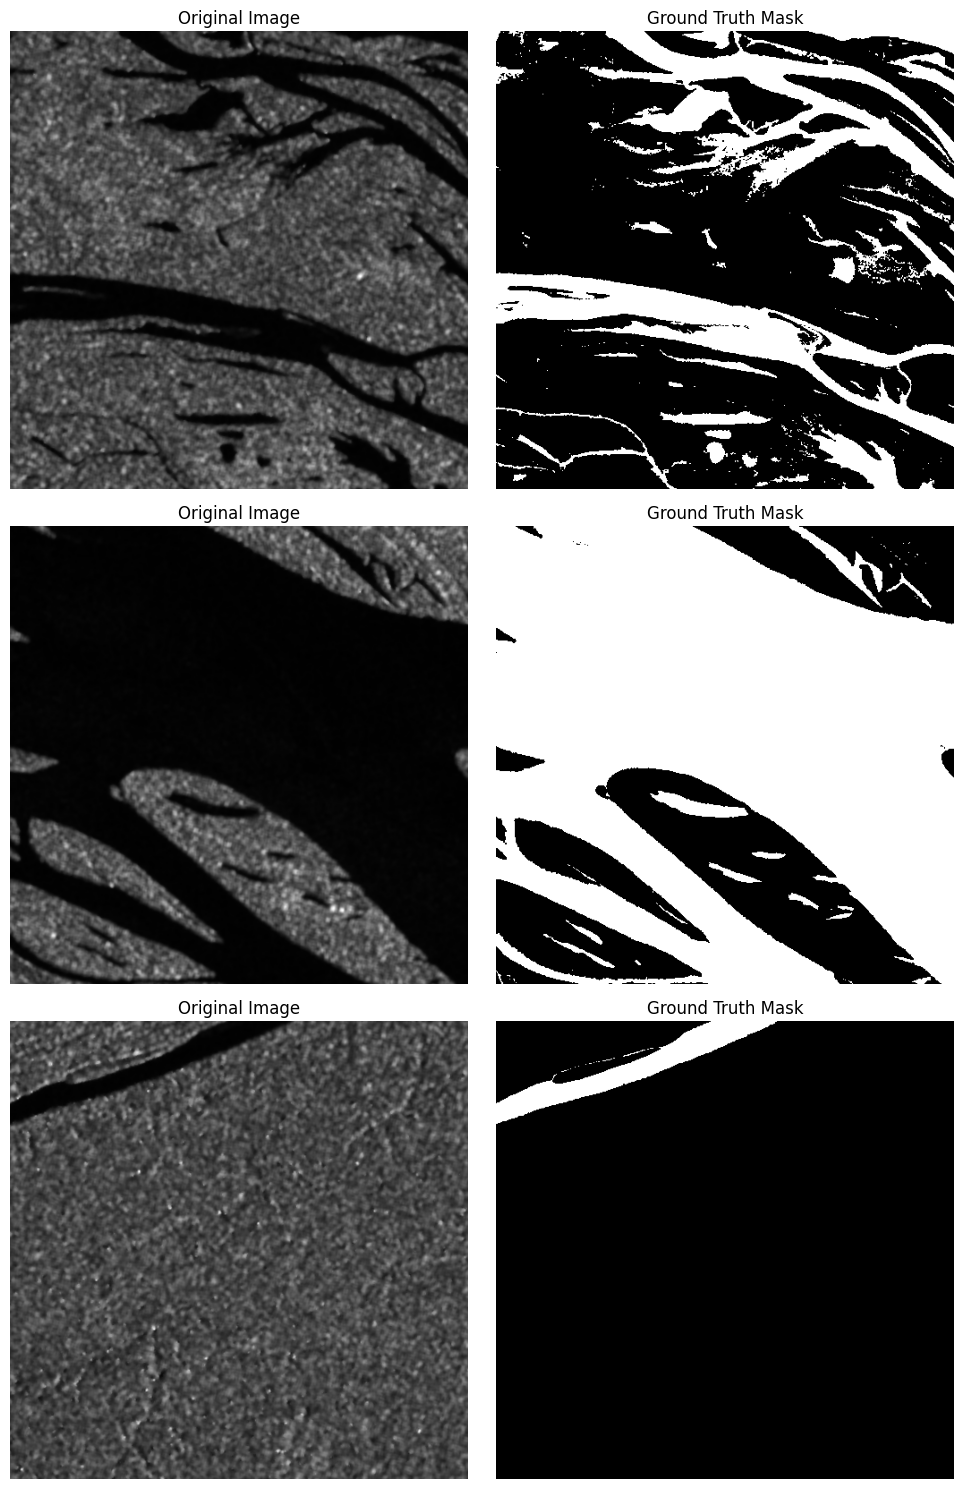

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms

# Define inverse normalization (adjust if your normalization differs)
#inv_normalize = transforms.Normalize(
 #   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
#    std=[1/0.229, 1/0.224, 1/0.225]
#)

# Set up the plot
num_samples = 3  # Number of samples to visualize
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

for i in range(num_samples):
    # Access the dictionary and extract tensors
    sample = train_dataset[i]
    image = sample["pixel_values"]  # Image tensor (C, H, W)
    mask = sample["labels"]        # Mask tensor (H, W)

    # Unnormalize the image and convert to NumPy array
    #image = inv_normalize(image)
    image = np.clip(image.permute(1, 2, 0).numpy(), 0, 1)  # (H, W, C)

    # Convert mask to NumPy array
    mask = mask.numpy()  # (H, W)

    # Plot original image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Plot ground truth mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

Saving 9.png to 9 (1).png


AttributeError: type object 'Image' has no attribute 'open'